If the OAP was cut with an offset and clocking angle that deviate from the design, it leads to different mechanical mounting parameters than as designed.

The question we are trying to answer:

We assume Nu-Tek measured the radius of curvature perfectly.
We assume that Nu-Tek cut the OAP at an unknown offset and clocking angle. As the result, we had to do translations and tilts to get back the almost perfect surface. Can we reverse-solve the problem and derive the offset and clocking angle?

Executive summary:

yes, the code below does the above. But the RMS difference (~118 microns) between the fitted surface and the ideal surface seems too large to be consistent with the small wavefront error we see in the lab.
The problem may be that there can be large uncertains in the translations and tilts that we determined with ltoptics, for example, due to the thickness and uniformity of the double-sided tape? I am not sure.

In [1]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
plt.jet();

<Figure size 432x288 with 0 Axes>

In [2]:
#everything in this cell is OAP1 specific; 
#when extending this to another OAP, make a copy of this cell and change the numbers accordingly.

oapR = 628.99 #radius of curvature, measured by NuTek
oapBeamD = oapR/2/222*6.949 # beam diameter on OAP, in mm;
# 222mm is the focal length of the focusing lens of the PhaseCam; 6.949mm is FOV width of PhaseCam; could use ~7mm
pixelSize = 0.1 #pixel size for this OAP surface map, in mm; this can be made smaller, but may take longer to run
offset0 = 60 #parent offset as specified
clocking0 = 180 #in the ideal scenario, OAP center is from 180° location on parent surface; 
#this assumes the line that goes thru OAP center and clocking mark is in parallel with +x axis.
#parent surface coordinate system has same +z as the optic local coordinate system below, 
# but +x and +y are reversed.

print('beam diameter on OAP = %.2f mm'%oapBeamD)

beam diameter on OAP = 9.84 mm


### build up the analytical surface

In [3]:
map_min = -100 #mm
map_max = 100 #mm
nPixel = int((map_max - map_min)/pixelSize)
xVec = np.linspace(map_min, map_max, nPixel+1)
yVec = np.linspace(map_min, map_max, nPixel+1)
[x, y] = np.meshgrid(xVec, yVec)

r2 = (x**2+y**2)
z= 1/oapR*r2
z[r2>map_max**2] = np.nan

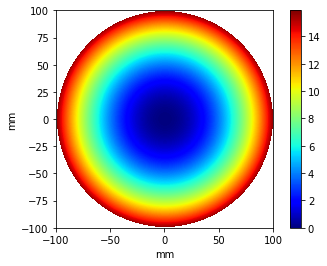

In [4]:
plt.imshow(z, extent=[map_min, map_max, map_min, map_max])
plt.xlabel('mm')
plt.ylabel('mm')
plt.colorbar();

(-110.0, 110.0, -0.7949251975389116, 16.693429148317144)

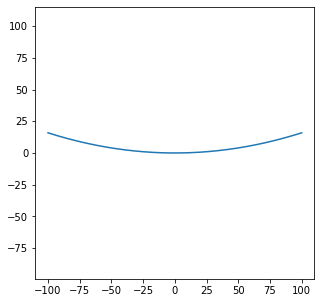

In [5]:
idx = y==0
fig, ax = plt.subplots(1,1, figsize=(5,5))
plt.plot(x[idx],z[idx])
#plt.plot(0,oapR,'o')
plt.axis('equal')

In [6]:
def cutout(offset, clocking, x, y, z, oapBeamD, lab_x, lab_y, lab_ry, lab_rx, lab_z):
    '''
    The returned arrays give the coordinates of the surface nodes AFTER 
    the translations and rotations that were done in the lab. (this is why we need lab_* as inputs)
    
    Note: just think about the piece of glass that was covered by light in the lab - call it P.
    The (offset+clocking) here points to P's center on the parent surface before it was cut out.
        This may not be center of the 2-inch circle that was actually cutout and shipped to us.
        P was cutout (with a big margin all around it), and placed into the beam, and tilted a bunch.
        The only way lab_x and lab_y matter here is they determine the center of the tilts.
        lab_x and lab_y have nothing to do with how far away P was from where it should be from on the parent surface.
    '''
    #these are the offsets with which we cut out the OAP
    offsetx = offset*np.cos(np.radians(clocking))
    offsety = offset*np.sin(np.radians(clocking))
    #without rounding to integer pixels, number of pixels will mismatch
    #we will deal with it outside of this function via interpolation
    
    #cutout the D=beam size.
    idx = ((x-offsetx)**2 + (y-offsety)**2 < (oapBeamD/2)**2)
    zcutout = z[idx]
    xcutout = x[idx]
    ycutout = y[idx]
    
    # now, move this piece like we did in the lab
    # #assume lab_* have been converted to OAP parent frame
    zcutout -= (xcutout-(offsetx+lab_x))*np.tan(np.radians(lab_ry))
    zcutout += (ycutout-(offsety+lab_y))*np.tan(np.radians(lab_rx))
    
    zcutout += lab_z

    #the below is just for plotting purposes
    # P is not moved into it mounted position by translation of (lab_x, lab_y)
    xcutout += lab_x 
    ycutout += lab_y
    
    return offsetx, offsety, xcutout, ycutout, zcutout

Below is just a sanity check that a randomly cut surface can be maneuvered to match the specified surface

(here we rely on lab_x and lab_y to move P into its mounted position - this is just for plotting purposes. In reality this is not true.)

In [7]:
offsetx, offsety, xcutout, ycutout, zcutout0 = cutout(offset0, clocking0, x, y, z, oapBeamD,0,0,0,0,0)
offsetx, offsety, xcutout1, ycutout1, zcutout1 = cutout(20, 180, x, y, z, oapBeamD,-40,0,7,0,10.)

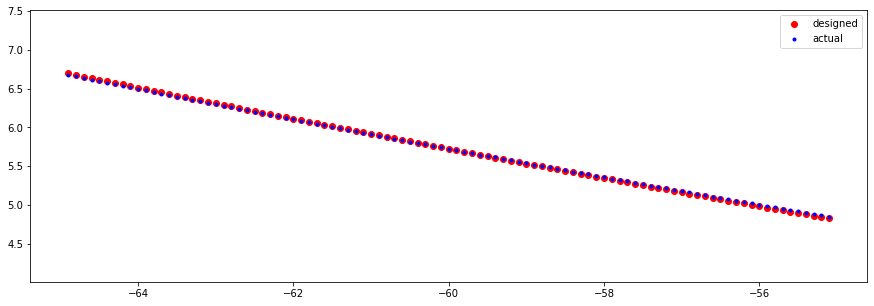

In [8]:
idx = ycutout==0
fig, ax = plt.subplots(1,1, figsize=(15,5))
plt.plot(xcutout[idx],zcutout0[idx],'ro', label='designed')
#plt.plot(0,oapR,'o')
plt.axis('equal')

idx = ycutout1 ==0
plt.plot(xcutout1[idx], zcutout1[idx],'b.', label='actual');
plt.legend()

### Define the maneuvers we had to do in the lab

In [9]:
#we measured the following in the lab
#+z points to FM2
#+y points up from bench
#+x points to OAP2 (according to RH rule)

lab_x = 0.114 #mm; to test: set to 5, rest at 0, P_center will be at x=-60mm. b/c you did not need tilt or piston
lab_y = 1.26 #mm; to test: set to 10, rest at 0, P_center will be at y=0mm. b/c you did not need tilt or piston
lab_h = -0.346 #deg; test: set to -2 (with lab_z = 1), P_center will be at x=-54mm
lab_v = 0.091 #deg; test: set to 1, rest at 0, P_center will be at y=+5mm
lab_z = 2.801 #mm; lab_z has to be tested together with lab_h. see above

#test sesssions (change these according to test descriptions above; check the scatter plot a few cells down.)
#lab_x = 0
#lab_y = 0
#lab_h = 0
#lab_v = 1
#lab_z = 0

#coordinate transformation, from optic's local frame to OAP parent frame
lab_x = -lab_x 
lab_y = -lab_y 
lab_h = -lab_h
lab_v = -lab_v 

Below, let's do a manual scan first, just to make sure things look right.

In [10]:
offsetx0, offsety0, xcutout0, ycutout0, zcutout0 = cutout(offset0, clocking0, x, y, z, oapBeamD,0,0,0,0,0)
plt_min = np.min(np.abs(zcutout0))
plt_max = np.max(np.abs(zcutout0))
#plt.scatter(xcutout, ycutout, np.abs(zcutout0), np.abs(zcutout0), vmin=plt_min, vmax=plt_max)
#plt.colorbar()

#print(zcutout0[1000])
offsetArray = np.arange(40,70,2)
clockingArray = np.arange(170, 190.1, 2)
offsetxArray = np.zeros(len(offsetArray)*len(clockingArray))
offsetyArray = np.zeros(len(offsetArray)*len(clockingArray))
rmsArray = np.zeros(len(offsetArray)*len(clockingArray))
i = 0
#fig, ax = plt.subplots(1,10, figsize=(20,2))
for offset in offsetArray:
    for clocking in clockingArray:
        #we do not care about x and y, therefore there is no good way to interpolate over subpixels
        #let's regenerate the pixel grid, so that zcutout and zcutout0 have the same number of pixels, 
        #.  then we can subtract directly
        offsetx = offset*np.cos(np.radians(clocking))
        offsety = offset*np.sin(np.radians(clocking))
        x1 = x + np.mod(offsetx, pixelSize)
        y1 = y + np.mod(offsety, pixelSize)

        r2 = (x1**2+y1**2)
        z= 1/oapR*r2
        z[r2>map_max**2] = np.nan
        
        offsetx, offsety, xcutout, ycutout, zcutout = cutout(
            offset, clocking, x1, y1, z, oapBeamD, lab_x, lab_y, lab_h, lab_v, lab_z)
    
        offsetxArray[i] = offsetx
        offsetyArray[i] = offsety
        #f = interpolate.interp2d(xcutout, ycutout, zcutout, kind='linear')
        rmsArray[i] = np.sqrt(np.mean((zcutout - zcutout0)**2))
        i+=1
        #if i<5:
        #    print(xcutout[-1], zcutout[-1], zcutout0[-1], rmsArray[i-1])
        #ax[i-1].scatter(xcutout, ycutout, np.abs(zcutout), np.abs(zcutout), vmin=plt_min, vmax=plt_max)
        #print('%5.1f, %5.1f %.3f'%(offsetx, offsety, np.std(zcutout - zcutout0)))

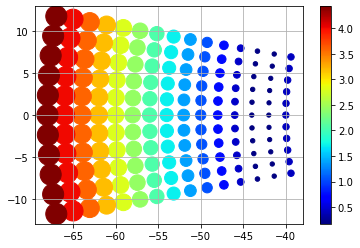

In [11]:
#fig, ax = plt.subplots(1,1, figsize=(15,12))
plt.scatter(offsetxArray, offsetyArray, rmsArray*100, rmsArray)
plt.grid()
plt.colorbar();

In [12]:
np.min(rmsArray)

0.17450407111394664

In [13]:
idxmin = rmsArray == np.min(rmsArray)

In [14]:
offsetxArray[idxmin], offsetyArray[idxmin]

(array([-42.]), array([5.14351656e-15]))

### Let's use fmin() to minimize the \chi^2

In [15]:
from scipy import optimize

In [16]:
def P_center_to_Mirror_offset(offset, clocking, lab_x, lab_y):
    '''
    once we've determined the center for the piece that was used to reflect light in the lab, 
    we use this function to calculate the center of the actual OAP cut.
    '''
    offsetx = offset*np.cos(np.radians(clocking))
    offsety = offset*np.sin(np.radians(clocking))
    offsetx += lab_x
    offsety += lab_y
    
    return np.sqrt(offsetx**2+offsety**2), np.rad2deg(np.arctan(offsety/offsetx))

In [17]:
def cutoutChi2(cutParam, x, y, z, oapBeamD, lab_x, lab_y, lab_h, lab_v, lab_z, zcutout0):
    '''
    This function calculates the chi2 between the actual cut surface and the ideal surface.
    This function is used with fmin() because the chi2 is what needs to be minimized.
    We assume (lab_x, lab_y, lab_h, lab_v, lab_z) have been measured with zero or negligible error.
    '''
    offset = cutParam[0]
    clocking = cutParam[1]
    
    #shift the grid a little, so that we always get the same number of pixels out of these surface.
    # this only changes the sampling of the surface.
    #the analytical surface itself is unchanged.
    offsetx = offset*np.cos(np.radians(clocking))
    offsety = offset*np.sin(np.radians(clocking))
    x1 = x + np.mod(offsetx, pixelSize)
    y1 = y + np.mod(offsety, pixelSize)

    r2 = (x1**2+y1**2)
    z= 1/oapR*r2
    z[r2>map_max**2] = np.nan

    offsetx, offsety, xcutout, ycutout, zcutout = cutout(offset, clocking, x1, y1, z, oapBeamD, 
                                                         lab_x, lab_y, lab_h, lab_v, lab_z)
    return np.mean((zcutout - zcutout0)**2)

In [18]:
xopt = optimize.fmin(
    lambda cutParam: cutoutChi2(cutParam, x, y, z, oapBeamD, lab_x, lab_y, lab_h, lab_v, lab_z, zcutout0),
    [-45, -1], disp=1)

offset_min = xopt[0]
clocking_min = xopt[1]
offset_min,clocking_min = P_center_to_Mirror_offset(xopt[0], xopt[1], lab_x, lab_y)
rms = np.sqrt(cutoutChi2(xopt, x, y, z, oapBeamD, lab_x, lab_y, lab_h, lab_v, lab_z, zcutout0))
print('offset from parent center = %.1f mm'%offset_min)
print('OAP clocking = %.2f deg'%clocking_min)
print('surface RMS error = %d microns'%(rms*1000))

Optimization terminated successfully.
         Current function value: 0.014122
         Iterations: 53
         Function evaluations: 106
offset from parent center = 43.1 mm
OAP clocking = 1.19 deg
surface RMS error = 118 microns


if we say, 'oh, we actually do not know lab_z that well, say, because of the double-sided tape'.

In [19]:
def cutoutChi2_zfloat(cutParam, x, y, z, oapBeamD, lab_x, lab_y, lab_h, lab_v, zcutout0):
    '''
    This function calculates the chi2 between the actual cut surface and the ideal surface.
    This function is used with fmin() because the chi2 is what needs to be minimized.
    We assume (lab_x, lab_y, lab_h, lab_v) have been measured with zero or negligible error.
    '''
    offset = cutParam[0]
    clocking = cutParam[1]
    lab_z = cutParam[2]
    
    offsetx = offset*np.cos(np.radians(clocking))
    offsety = offset*np.sin(np.radians(clocking))
    x1 = x + np.mod(offsetx, pixelSize)
    y1 = y + np.mod(offsety, pixelSize)

    r2 = (x1**2+y1**2)
    z= 1/oapR*r2
    z[r2>map_max**2] = np.nan

    offsetx, offsety, xcutout, ycutout, zcutout = cutout(offset, clocking, x1, y1, z, oapBeamD, 
                                                         lab_x, lab_y, lab_h, lab_v, lab_z)
    #this is our way of imposing bounds to fit. minimize() can do this, but it seems very slow
    if lab_z > 3.3 or lab_z < 2.5: 
        zcutout += 1e10
    return np.mean((zcutout - zcutout0)**2)

In [20]:
xopt = optimize.fmin(
    lambda cutParam: cutoutChi2_zfloat(cutParam, x, y, z, oapBeamD, lab_x, lab_y, lab_h, lab_v, zcutout0),
    [-45, -1, 2.8], disp=1)

offset_min = xopt[0]
clocking_min = xopt[1]
offset_min,clocking_min = P_center_to_Mirror_offset(xopt[0], xopt[1], lab_x, lab_y)
lab_z_min = xopt[2]
rms = np.sqrt(cutoutChi2_zfloat(xopt, x, y, z, oapBeamD, lab_x, lab_y, lab_h, lab_v, zcutout0))
print('offset from parent center = %.1f mm'%offset_min)
print('OAP clocking = %.2f deg'%clocking_min)
print('OAP z translation = %.2f mm'%lab_z_min)
print('surface RMS error = %d microns'%(rms*1000))

Optimization terminated successfully.
         Current function value: 0.010425
         Iterations: 91
         Function evaluations: 171
offset from parent center = 45.2 mm
OAP clocking = 0.56 deg
OAP z translation = 2.50 mm
surface RMS error = 102 microns


if we say, 'oh, we actually do not know lab_h that well, say, because of the double-sided tape'.

In [21]:
def cutoutChi2_hfloat(cutParam, x, y, z, oapBeamD, lab_x, lab_y, lab_v, lab_z, zcutout0):
    '''
    This function calculates the chi2 between the actual cut surface and the ideal surface.
    This function is used with fmin() because the chi2 is what needs to be minimized.
    We assume (lab_x, lab_y, lab_v, lab_z) have been measured with zero or negligible error.
    '''
    offset = cutParam[0]
    clocking = cutParam[1]
    lab_h = cutParam[2]
    
    offsetx = offset*np.cos(np.radians(clocking))
    offsety = offset*np.sin(np.radians(clocking))
    x1 = x + np.mod(offsetx, pixelSize)
    y1 = y + np.mod(offsety, pixelSize)

    r2 = (x1**2+y1**2)
    z= 1/oapR*r2
    z[r2>map_max**2] = np.nan
        
    offsetx, offsety, xcutout, ycutout, zcutout = cutout(offset, clocking, x1, y1, z, oapBeamD, 
                                                         lab_x, lab_y, lab_h, lab_v, lab_z)
    #this is our way of imposing bounds to fit. minimize() can do this, but it seems very slow
    if lab_h > 0 or lab_h < -5:
        zcutout += 1e10
    return np.mean((zcutout - zcutout0)**2)

In [22]:
xopt = optimize.fmin(
    lambda cutParam: cutoutChi2_hfloat(cutParam, x, y, z, oapBeamD, lab_x, lab_y, lab_v, lab_z, zcutout0),
    [-45, -1, -.346], disp=1)

offset_min = xopt[0]
clocking_min = xopt[1]
lab_h_min = xopt[2]
offset_min,clocking_min = P_center_to_Mirror_offset(xopt[0], xopt[1], lab_x, lab_y)
rms = np.sqrt(cutoutChi2_hfloat(xopt, x, y, z, oapBeamD, lab_x, lab_y, lab_v, lab_z, zcutout0))
print('offset from parent center = %.1f mm'%offset_min)
print('OAP clocking = %.2f deg'%clocking_min)
print('OAP H tilt = %.2f deg'%lab_h_min)
print('surface RMS error = %d microns'%(rms*1000))

Optimization terminated successfully.
         Current function value: 0.017881
         Iterations: 123
         Function evaluations: 232
offset from parent center = 43.1 mm
OAP clocking = 1.06 deg
OAP H tilt = -0.00 deg
surface RMS error = 133 microns


In [23]:
lab_h

0.346

if we say, 'oh, we actually are not confident with any of those lab measurements'.

In [24]:
def cutoutChi2_allfloat(cutParam, x, y, z, oapBeamD, zcutout0):
    '''
    This function calculates the chi2 between the actual cut surface and the ideal surface.
    This function is used with fmin() because the chi2 is what needs to be minimized.
    We assume NONE of (lab_x, lab_y, lab_h, lab_v, lab_z) have been measured with zero or negligible error.
    '''
    offset = cutParam[0]
    clocking = cutParam[1]
    lab_z = cutParam[2]
    lab_x = cutParam[3] 
    lab_y = cutParam[4] 
    lab_h = cutParam[5]
    lab_v = cutParam[6]
    
    offsetx = offset*np.cos(np.radians(clocking))
    offsety = offset*np.sin(np.radians(clocking))
    x1 = x + np.mod(offsetx, pixelSize)
    y1 = y + np.mod(offsety, pixelSize)

    r2 = (x1**2+y1**2)
    z= 1/oapR*r2
    z[r2>map_max**2] = np.nan

    offsetx, offsety, xcutout, ycutout, zcutout = cutout(offset, clocking, x1, y1, z, oapBeamD, 
                                                         lab_x, lab_y, lab_h, lab_v, lab_z)
    return np.mean((zcutout - zcutout0)**2)

In [25]:
xopt = optimize.fmin(
    lambda cutParam: cutoutChi2_allfloat(cutParam, x, y, z, oapBeamD, zcutout0),
    [-45, 0, 0, 0, 0, 0, 0], disp=1)

offset_min = xopt[0]
clocking_min = xopt[1]
lab_z_min = xopt[2]
lab_x_min = xopt[3]
lab_y_min = xopt[4]
offset_min,clocking_min = P_center_to_Mirror_offset(xopt[0], xopt[1], lab_x_min, lab_y_min)
rms = cutoutChi2_allfloat(xopt, x, y, z, oapBeamD, zcutout0)
print('offset from parent center = %.1f mm'%offset_min)
print('OAP clocking = %.2f deg'%clocking_min)
print('surface RMS error = %d microns'%(rms*1000))

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 129
         Function evaluations: 251
offset from parent center = 60.0 mm
OAP clocking = 0.00 deg
surface RMS error = 0 microns


### Below are experimental features; Ignore for now!

(trying a different way to impose upper and lower bounds for the fit)

In [ ]:
xopt = optimize.minimize(
    lambda cutParam: cutoutChi2_zfloat(cutParam, x, y, z, oapBeamD, lab_x, lab_y, lab_h, lab_v, zcutout0), (-60, 0, 2),
    bounds = ((-100, -30), (-10, 0), (2, 3.5)), tol=1.e-16)

print(xopt.message)
offset_min = xopt.x[0]
clocking_min = xopt.x[1]
lab_z_min = xopt.x[2]
rms = cutoutChi2_zfloat(xopt.x, x, y, z, oapBeamD, lab_x, lab_y, lab_h, lab_v, zcutout0)
print(offset_min, clocking_min, lab_z_min, rms)

In [ ]:
xopt